In [1]:
# import required modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from infrasim.component import Component

In [2]:
# create a component object with your name of choice
component =  Component(name='component-1', inspect_cost=1.0, replace_cost=60.0, dynamics_scale=36.92, dynamics_shape=1.77)

In [13]:
# run a policy on the component with baseline strategy
budget_remaining = 1000
inspect_interval = 5
replace_failure_threshold = 0.5
num_steps = 0
last_known_state = 100

component.reset()
while budget_remaining > 0 and num_steps < 100:

    # inspection
    if num_steps % inspect_interval == 0:
        component.update(action=1)
        budget_remaining -= component.inspect_cost
        last_known_state = component.current_state
    else:
        component.update(action=0)

    # replacement
    fail_prob = component.get_failure_probability(last_known_state)
    print(f'Step {num_steps}: Current known state - {last_known_state} | current fail prob - {fail_prob} | remaining budget - {budget_remaining}')

    if component.get_failure_probability(last_known_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
        component.update(action=2)
        budget_remaining -= component.replace_cost
        last_known_state = component.current_state

    num_steps += 1

Step 0: Current known state - 71 | current fail prob - 0.003191903644596047 | remaining budget - 999.0
Step 1: Current known state - 71 | current fail prob - 0.003191903644596047 | remaining budget - 999.0
Step 2: Current known state - 71 | current fail prob - 0.003191903644596047 | remaining budget - 999.0
Step 3: Current known state - 71 | current fail prob - 0.003191903644596047 | remaining budget - 999.0
Step 4: Current known state - 71 | current fail prob - 0.003191903644596047 | remaining budget - 999.0
Step 5: Current known state - 0 | current fail prob - 1.0 | remaining budget - 998.0
Step 6: Current known state - 100 | current fail prob - 0.00027537680918520026 | remaining budget - 938.0
Step 7: Current known state - 100 | current fail prob - 0.00027537680918520026 | remaining budget - 938.0
Step 8: Current known state - 100 | current fail prob - 0.00027537680918520026 | remaining budget - 938.0
Step 9: Current known state - 100 | current fail prob - 0.00027537680918520026 | r

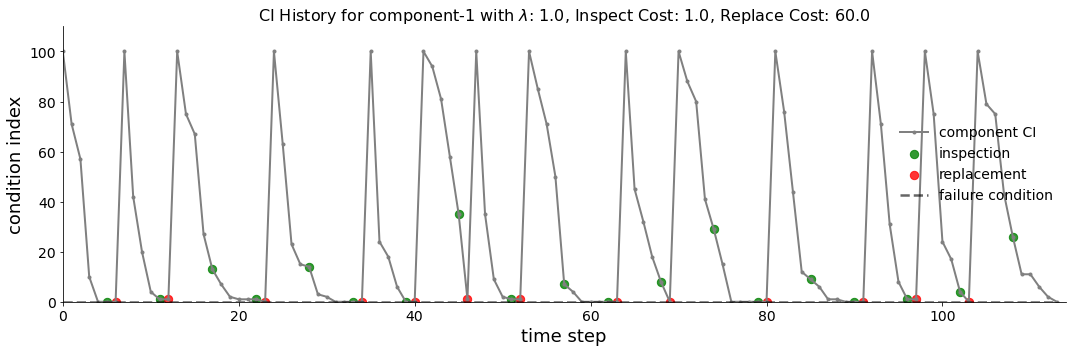

In [14]:
# Visualize the state and action history of the component
component.visualize_history()